Установка Spark и зависимостей

In [ ]:
# Установка Java и Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar -xvzf spark-3.3.1-bin-hadoop3.tgz > /dev/null
!pip install -q findspark gdown


Настройка переменных среды и запуск SparkSession

In [ ]:
import os
import findspark

os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ['SPARK_HOME'] = '/content/spark-3.3.1-bin-hadoop3'

findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("EDA with PySpark") \
    .getOrCreate()

spark


Скачивание архива с Google Drive и распаковка

In [ ]:
# Установка библиотеки для скачивания с Google Drive
!pip install -q gdown

# Скачивание архива с Google Диска (файл весит >1 ГБ, может занять время)
!gdown --id 1yiAp1fFDy3wSqUR0X_btCZPtuczbLwCe

# Проверим, что файл скачался
!ls -lh

# Распаковка архива (предположим, это zip)
!unzip -o *.zip -d data

# Проверим содержимое папки data
!ls -lh data


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1yiAp1fFDy3wSqUR0X_btCZPtuczbLwCe
From (redirected): https://drive.google.com/uc?id=1yiAp1fFDy3wSqUR0X_btCZPtuczbLwCe&confirm=t&uuid=161d4422-cf54-4159-9b7c-6835e46cf1cd
To: /content/endomondoHR.json.zip
100% 2.02G/2.02G [00:33<00:00, 60.2MB/s]
total 2.9G
-rw-r--r--  1 root      root 1.9G Apr  1  2024 endomondoHR.json.zip
drwxr-xr-x  1 root      root 4.0K Apr 10 13:37 sample_data
drwxr-xr-x 13 110302528 1000 4.0K Oct 15  2022 spark-3.3.1-bin-hadoop3
-rw-r--r--  1 root      root 286M Oct 15  2022 spark-3.3.1-bin-hadoop3.tgz
-rw-r--r--  1 root      root 286M Oct 15  2022 spark-3.3.1-bin-hadoop3.tgz.1
-rw-r--r--  1 root      root 286M Oct 15  2022 spark-3.3.1-bin-hadoop3.tgz.2
-rw-r--r--  1 root      root 168M

Загрузка и отображение JSON-файла

In [ ]:
# Чтение JSON-файла в Spark DataFrame
df = spark.read.json("data/endomondoHR.json")

# Вывод структуры
df.printSchema()

# Просмотр первых строк
df.show(5, truncate=False)


root
 |-- altitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- gender: string (nullable = true)
 |-- heart_rate: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- id: long (nullable = true)
 |-- latitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- longitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- speed: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- sport: string (nullable = true)
 |-- timestamp: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- url: string (nullable = true)
 |-- userId: long (nullable = true)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Подсчет средней высоты (altitude) по каждой тренировке

In [ ]:
from pyspark.sql.functions import expr

# Добавим столбец средней высоты
df = df.withColumn("altitude_avg", expr("aggregate(altitude, 0D, (acc, x) -> acc + x) / size(altitude)"))

df.select("altitude_avg").show(10)


+------------------+
|      altitude_avg|
+------------------+
| 43.07119999999995|
| 35.72479999999995|
| 62.42559999999998|
| 32.61040000000001|
| 22.76199999999996|
| 39.73839999999986|
|13.364000000000027|
|  9.05680000000001|
| 3.761600000000003|
|22.191200000000013|
+------------------+
only showing top 10 rows



Визуализация распределения средней высоты

In [ ]:
print('Обзор данных')
df.printSchema()
print('Обзор столбцов')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Обзор данных
root
 |-- altitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- gender: string (nullable = true)
 |-- heart_rate: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- id: long (nullable = true)
 |-- latitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- longitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- speed: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- sport: string (nullable = true)
 |-- timestamp: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- url: string (nullable = true)
 |-- userId: long (nullable = true)
 |-- altitude_avg: double (nullable = true)
 |-- pace_level: integer (nullable = true)

Обзор столбцов


,Column Name,Data type
0,altitude,array<double>
1,gender,string
2,heart_rate,array<bigint>
3,id,bigint
4,latitude,array<double>
5,longitude,array<double>
6,speed,array<double>
7,sport,string
8,timestamp,array<bigint>
9,url,string


Описание скалярных столбцов

In [ ]:
# Только скалярные числовые или строковые типы
allowed_types = ['string', 'double', 'int', 'long']
numeric_string_cols = [f.name for f in df.schema.fields if f.dataType.simpleString() in allowed_types]

print("Колонки для описания:", numeric_string_cols)


Колонки для описания: ['gender', 'sport', 'url', 'altitude_avg', 'pace_level']


In [ ]:
print('Обзор столбцов')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Обзор столбцов


,Column Name,Data type
0,altitude,array<double>
1,gender,string
2,heart_rate,array<bigint>
3,id,bigint
4,latitude,array<double>
5,longitude,array<double>
6,speed,array<double>
7,sport,string
8,timestamp,array<bigint>
9,url,string


Распределение по sport

<ipython-input-41-ee293feb9a4b>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sport_counts, x='sport', y='count', palette='viridis')


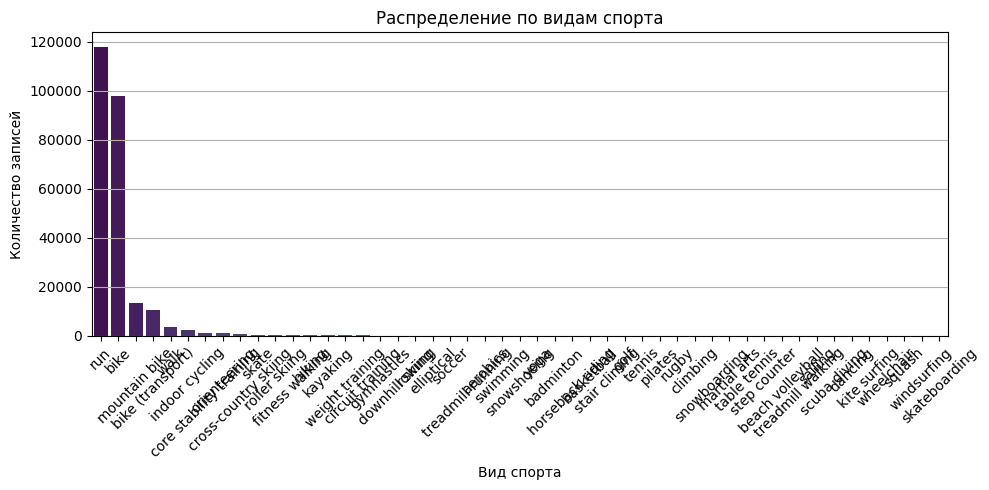

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Преобразуем в Pandas и считаем количество каждого типа спорта
sport_pd = df.select("sport").dropna().toPandas()
sport_counts = sport_pd['sport'].value_counts().reset_index()
sport_counts.columns = ['sport', 'count']

# Визуализация
plt.figure(figsize=(10, 5))
sns.barplot(data=sport_counts, x='sport', y='count', palette='viridis')
plt.title("Распределение по видам спорта")
plt.xlabel("Вид спорта")
plt.ylabel("Количество записей")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Распределение по gender

<ipython-input-42-da0dca0a955d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gender_counts, x='gender', y='count', palette='pastel')


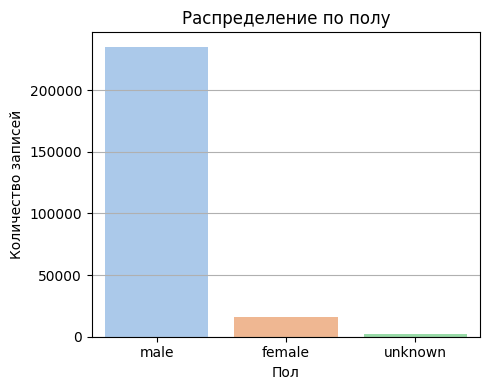

In [ ]:
# Преобразуем в Pandas и считаем количество по полу
gender_pd = df.select("gender").dropna().toPandas()
gender_counts = gender_pd['gender'].value_counts().reset_index()
gender_counts.columns = ['gender', 'count']

# Визуализация
plt.figure(figsize=(5, 4))
sns.barplot(data=gender_counts, x='gender', y='count', palette='pastel')
plt.title("Распределение по полу")
plt.xlabel("Пол")
plt.ylabel("Количество записей")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Boxplot altitude_avg по полу

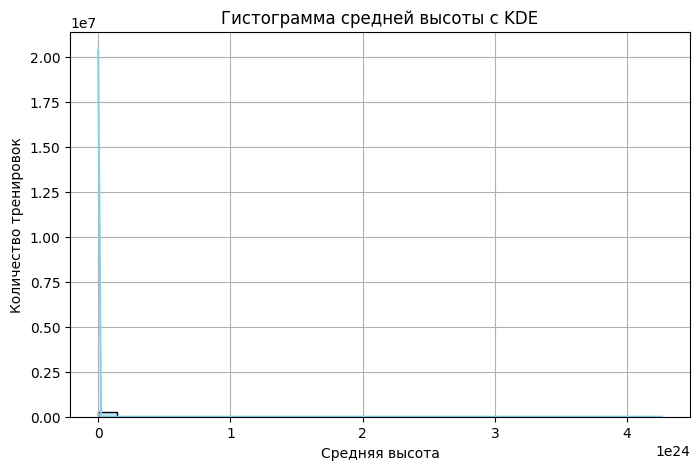

In [ ]:
alt_pd = df.select("altitude_avg").dropna().toPandas()

plt.figure(figsize=(8, 5))
sns.histplot(alt_pd["altitude_avg"], bins=30, kde=True, color='skyblue')
plt.title("Гистограмма средней высоты с KDE")
plt.xlabel("Средняя высота")
plt.ylabel("Количество тренировок")
plt.grid(True)
plt.show()


Круговая диаграмма по полу

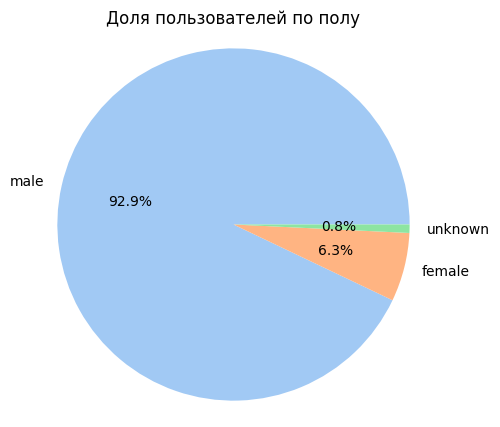

In [ ]:
gender_counts = df.select("gender").dropna().toPandas()["gender"].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Доля пользователей по полу")
plt.axis('equal')
plt.show()


Средняя скорость (speed) vs средний пульс (heart_rate)

In [ ]:
from pyspark.sql.functions import expr

df = df.withColumn("avg_speed", expr("aggregate(speed, 0D, (acc, x) -> acc + x) / size(speed)"))
df = df.withColumn("avg_heart_rate", expr("aggregate(heart_rate, 0D, (acc, x) -> acc + x) / size(heart_rate)"))


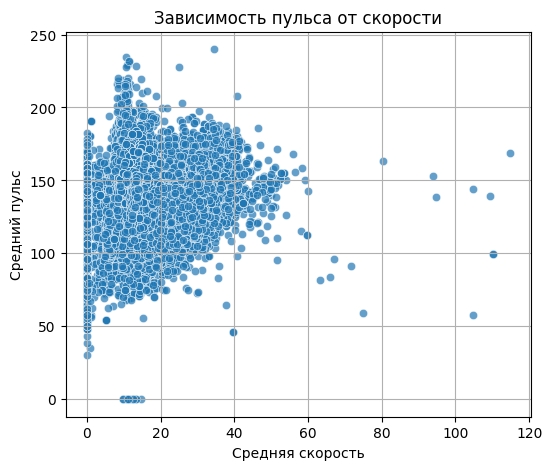

In [ ]:
hr_speed_pd = df.select("avg_speed", "avg_heart_rate").dropna().toPandas()

plt.figure(figsize=(6, 5))
sns.scatterplot(data=hr_speed_pd, x="avg_speed", y="avg_heart_rate", alpha=0.7)
plt.title("Зависимость пульса от скорости")
plt.xlabel("Средняя скорость")
plt.ylabel("Средний пульс")
plt.grid(True)
plt.show()


Построение маршрута (по latitude и longitude)

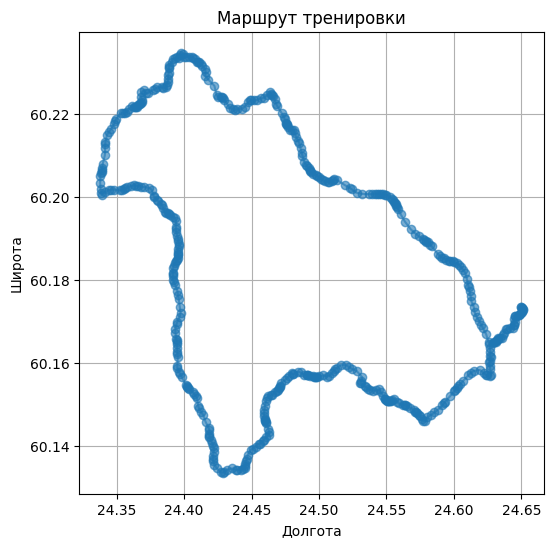

In [ ]:
sample = df.select("latitude", "longitude").dropna().limit(1).collect()[0]
lat_list = sample["latitude"]
lon_list = sample["longitude"]

plt.figure(figsize=(6, 6))
plt.plot(lon_list, lat_list, marker='o', linestyle='-', alpha=0.6)
plt.title("Маршрут тренировки")
plt.xlabel("Долгота")
plt.ylabel("Широта")
plt.grid(True)
plt.show()


Линейный график — как меняется пульс в одной тренировке

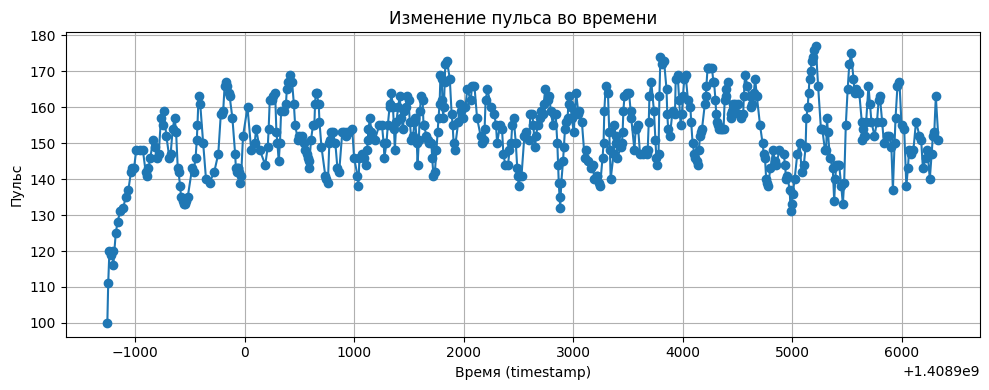

In [ ]:
# Выбираем одну тренировку
sample = df.select("heart_rate", "timestamp").dropna().limit(1).collect()[0]
hr_list = sample['heart_rate']
time_list = sample['timestamp']

# Построение
plt.figure(figsize=(10, 4))
plt.plot(time_list, hr_list, marker='o')
plt.title("Изменение пульса во времени")
plt.xlabel("Время (timestamp)")
plt.ylabel("Пульс")
plt.grid(True)
plt.tight_layout()
plt.show()
